In [1]:
import pandas as pd
import numpy as np
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


In [2]:
data=pd.read_csv(r'C:\Users\kiran\OneDrive\Desktop\Shreya\KRR\clothing.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'ProductCategory' is a categorical column in your dataset
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender']) 
data['NewPrice']= 0
data= data.drop('ProductCategory', axis=1)

In [4]:

from sklearn.preprocessing import MinMaxScaler

# Assuming your dataset is stored in a DataFrame named 'data'
# and you want to normalize all columns

# Extract numerical columns (you might need to adjust this based on your data)
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])


In [5]:
state_features = ['Age', 'Gender', 'ProductPrice', 'ProductCost', 'Profit', 'FootTraffic', 'InventoryLevel', 'CompetitorPrice', 'PurchaseMonth', 'PurchaseQuarter', 'DayOfWeek','ProductType','NewPrice']
actions = [0.05, 0.1, -0.05, -0.1]

In [6]:
# Function to calculate reward for a given action
def calculate_reward_for_action(state, action, competitor_price_threshold=0.05, product_price_threshold=0.1):
   
    # Assuming 'ProductPrice' is at index 2 in the state array
    product_price_index = 2
    new_price_index=12
    penalty=0
    # Calculate new product price based on the action
    state[new_price_index] = state[product_price_index] * (1 + float(action))
    
    # Calculate profit
    profit = state[new_price_index] - state[3]  # Assuming 'ProductCost' is at index 4 in the state array
    
    # Check proximity to competitor price
    if abs(state[new_price_index] - state[7]) < competitor_price_threshold * state[7]:  # Assuming 'CompetitorPrice' is at index 8
        # Apply penalty for being near competitor price
        penalty= -5 # Assuming 'ProductCost' is at index 4
    
    # Check proximity to original product price
    if abs(state[new_price_index] - state[2]) < product_price_threshold * state[2]:
        # Apply penalty for being near original product price
        penalty =-3 # Assuming 'ProductCost' is at index 4
        
#     if state[new_price_index] < 1.3* state[product_price_index]:
#         state[product_price_index]= state[new_price_index]
        
    reward=(profit-penalty)/2
    state[product_price_index]= state[new_price_index]
    return reward

In [7]:
data.shape

(35, 13)

In [8]:
# Generate synthetic dataset
synthetic_data = []

for index, row in data.iterrows():
    state = row[state_features]
    
    for action in actions:
        next_state = state.copy()
        next_state['ProductPrice'] *= (1 + action)
        
        reward = calculate_reward_for_action(state, action)
        
        sample = {
            'state': state.tolist(),
            'action': action,
            'next_state': next_state.tolist(),
            'reward': reward
        }
        
        synthetic_data.append(sample)

# Convert the list of dictionaries to a DataFrame
syndf = pd.DataFrame(synthetic_data, columns=['state', 'action', 'next_state', 'reward'])


In [9]:
syndf.shape

(140, 4)

In [10]:


class ReplayMemory:
    def __init__(self):
        self.capacity = 1000  # You can adjust the capacity if needed
        self.memory = []

    def push(self, transition):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# Initialize replay memory
replay_memory = ReplayMemory()




In [11]:
# Define epsilon-greedy exploration
def epsilon_greedy_action_selection(model, state, actions, epsilon):
    if np.random.rand() < epsilon:
        # Exploration: Choose a random action
        action = np.random.choice(actions)
    else:
        # Exploitation: Choose the action with the highest Q-value
        q_values = model.predict(np.array([state]))
        action = actions[np.argmax(q_values)]
    return action

In [12]:
# Extract state, action, next_state, and reward
states = np.array(syndf['state'].tolist())
actions = np.array(syndf['action'])
next_states = np.array(syndf['next_state'].tolist())
rewards = np.array([calculate_reward_for_action(states[i], actions[i]) for i in range(len(actions))])


In [13]:
from keras.optimizers import Adam

# Define the DQN model
model = Sequential()
model.add(Dense(64, input_shape=(len(state_features),), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='linear'))  # Output layer

# Compile the model with a specific learning rate
custom_optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
model.compile(optimizer=custom_optimizer, loss='mse')

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Training the DQN
history=model.fit(states, rewards, epochs=20, batch_size=32, validation_split=0.2)

# Print the training history
print(history.history)



Epoch 1/20

4/4 [==============================] - 7s 404ms/step - loss: 1.5946 - val_loss: 1.2270
Epoch 2/20
4/4 [==============================] - 0s 72ms/step - loss: 1.5190 - val_loss: 1.1676
Epoch 3/20
4/4 [==============================] - 0s 97ms/step - loss: 1.4347 - val_loss: 1.0992
Epoch 4/20
4/4 [==============================] - 0s 63ms/step - loss: 1.3337 - val_loss: 1.0175
Epoch 5/20
4/4 [==============================] - 0s 68ms/step - loss: 1.2087 - val_loss: 0.9222
Epoch 6/20
4/4 [==============================] - 0s 67ms/step - loss: 1.0637 - val_loss: 0.8202
Epoch 7/20
4/4 [==============================] - 0s 83ms/step - loss: 0.9155 - val_loss: 0.7269
Epoch 8/20
4/4 [==============================] - 0s 68ms/step - loss: 0.8064 - val_loss: 0.6670
Epoch 9/20
4/4 [==============================] - 0s 63ms/step - loss: 0.6986 - val_loss: 0.6408
Epoch 10/20
4/4 [==============================] - 0s 67ms/step - loss: 0.6619 - val_loss: 0.6298
Epoch 11/20
4/4 [========

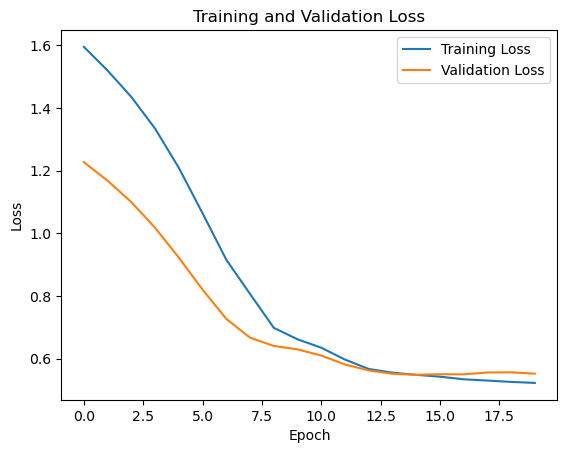

In [14]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [15]:
# Target Network
target_model = Sequential()
target_model.add(Dense(64, input_shape=(len(states[0]),), activation='relu'))
target_model.add(Dense(64, activation='relu'))
target_model.add(Dense(len(actions), activation='linear'))
target_model.compile(optimizer='adam', loss='mse')
target_model.set_weights(model.get_weights())  # Initialize target network with current model weights
epoch_rewards=[]


In [16]:
# Initialize epsilon and decay parameters
epsilon = 0.1  # Initial epsilon value, you can adjust this
epsilon_decay = 0.99  # Decay factor for epsilon, adjust as needed

epoch_rewards = []
cumulative_rewards = []  # Store cumulative rewards over epochs

for e in range(20):
    total_epoch_reward = 0
    
    for i in range(len(actions)):
        state = states[i]
        action = epsilon_greedy_action_selection(model, state, actions, epsilon)
        reward = calculate_reward_for_action(state, action)
        next_state = next_states[i]

        replay_memory.push((state, action, reward, next_state))

        # Sample a random mini-batch from replay memory
        batch_size = 32
        if len(replay_memory.memory) >= batch_size:
            transitions = replay_memory.sample(batch_size)
            batch_states, batch_actions, batch_rewards, batch_next_states = zip(*transitions)

            target_q_values = target_model.predict(np.array(batch_next_states))
            max_target_q_values = np.max(target_q_values, axis=1)
            target_q_values_for_actions = batch_rewards + 0.99 * max_target_q_values

            model.fit(np.array(batch_states), target_q_values_for_actions, epochs=1, verbose=0)

    if e % 5 == 0:
        target_model.set_weights(model.get_weights())

    epoch_reward = np.sum([calculate_reward_for_action(states[i], actions[i]) for i in range(len(actions))])
    epoch_rewards.append(epoch_reward)
    cumulative_rewards.append(np.sum(epoch_rewards))  # Calculate cumulative reward

    # Print the reward gained and cumulative reward in this epoch
    print(f'Epoch {e + 1} - Reward: {epoch_reward} - Cumulative Reward: {cumulative_rewards[-1]}')

    # Decay epsilon
    epsilon *= epsilon_decay




1/1 [==============================] - 0s 193ms/step
Epoch 1 - Reward: 139.5839150734662 - Cumulative Reward: 139.5839150734662
1/1 [==============================] - 0s 118ms/step
Epoch 2 - Reward: 141.44071287075775 - Cumulative Reward: 281.02462794422394
1/1 [==============================] - 0s 160ms/step
Epoch 3 - Reward: 143.66955032487687 - Cumulative Reward: 424.6941782691008
1/1 [==============================] - 0s 130ms/step
Epoch 4 - Reward: 141.9451336011644 - Cumulative Reward: 566.6393118702651
1/1 [==============================] - 0s 157ms/step
Epoch 5 - Reward: 143.856967026114 - Cumulative Reward: 710.4962788963792
1/1 [==============================] - 0s 110ms/step
Epoch 6 - Reward: 146.10902134683118 - Cumulative Reward: 856.6053002432104
1/1 [==============================] - 0s 129ms/step
Epoch 7 - Reward: 156.71150891563474 - Cumulative Reward: 1013.3168091588452
1/1 [==============================] - 0s 110ms/step
Epoch 8 - Reward: 149.4766148874694 - Cumulati

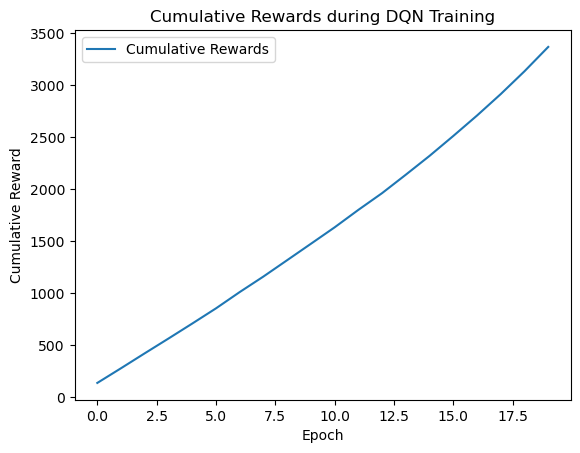

In [17]:
# Plot the cumulative rewards
plt.plot(cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Epoch')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards during DQN Training')
plt.legend()
plt.show()

In [18]:
epoch_rewards

[139.5839150734662,
 141.44071287075775,
 143.66955032487687,
 141.9451336011644,
 143.856967026114,
 146.10902134683118,
 156.71150891563474,
 149.4766148874694,
 157.197789917428,
 157.63196715003266,
 158.13587873426604,
 167.8883515607958,
 161.06581470220215,
 177.33873236013113,
 181.01337586061675,
 191.41537471222233,
 196.4283034228499,
 206.32957951301955,
 219.3130575345229,
 233.95644619189127]

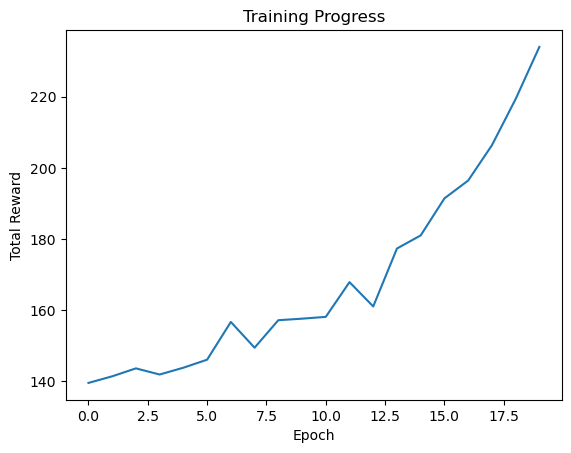

In [19]:
import matplotlib.pyplot as plt
# Plotting the training progress
plt.plot(epoch_rewards)
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

# Q Learning


In [20]:
import numpy as np
import pandas as pd
import random

# Define the Q-learning algorithm
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.001, discount_factor=0.99, exploration_prob=0.5):
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.q_values = {}

    def get_q_value(self, state, action):
        return self.q_values.get((tuple(state), action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(self.actions, key=lambda a: self.get_q_value(next_state, a))
        new_q_value = (1 - self.learning_rate) * self.get_q_value(state, action) + \
                      self.learning_rate * (reward + self.discount_factor * self.get_q_value(next_state, best_next_action))
        self.q_values[(tuple(state), action)] = new_q_value

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_prob:
            return random.choice(self.actions)
        else:
            return max(self.actions, key=lambda a: self.get_q_value(state, a))

# Initialize Q-learning agent
q_learning_agent = QLearningAgent(actions)



Epoch 1 - Total Reward: 140.55867328348072
Epoch 2 - Total Reward: 148.43874286866557
Epoch 3 - Total Reward: 139.56760212293642
Epoch 4 - Total Reward: 138.94884368148576
Epoch 5 - Total Reward: 137.08817688326062
Epoch 6 - Total Reward: 138.4934631771636
Epoch 7 - Total Reward: 156.6747717673074
Epoch 8 - Total Reward: 149.64445585008798
Epoch 9 - Total Reward: 148.41724999590502
Epoch 10 - Total Reward: 154.51038943196016
Epoch 11 - Total Reward: 158.94375219167236
Epoch 12 - Total Reward: 160.7400253129154
Epoch 13 - Total Reward: 158.4248964935818
Epoch 14 - Total Reward: 171.52727285107147
Epoch 15 - Total Reward: 165.57952868444497
Epoch 16 - Total Reward: 179.6177844065637
Epoch 17 - Total Reward: 188.18221910104873
Epoch 18 - Total Reward: 191.3174194680323
Epoch 19 - Total Reward: 189.07276825630765
Epoch 20 - Total Reward: 207.00287564068674


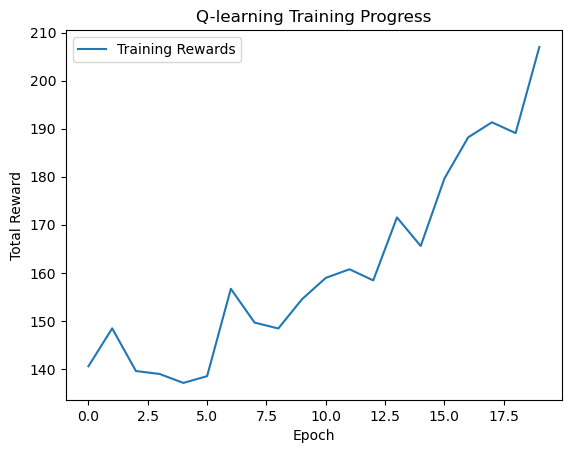

In [21]:


# Q-learning training
training_rewards = []

for epoch in range(20):
    total_reward = 0
    for i in range(len(synthetic_data)):
        state = synthetic_data[i]['state']
        action = synthetic_data[i]['action']
        reward = calculate_reward_for_action(state, action)
        next_state = synthetic_data[i]['next_state']

        # Update Q-values
        q_learning_agent.update_q_value(state, action, reward, next_state)

        total_reward += reward

    training_rewards.append(total_reward)
    print(f'Epoch {epoch + 1} - Total Reward: {total_reward}')

# Plot the training rewards
plt.plot(training_rewards, label='Training Rewards')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.title('Q-learning Training Progress')
plt.legend()
plt.show()
